In [0]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Install miniconda and rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2019-10-17 05:36:06--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70489432 (67M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  67.22M   156MB/s    in 0.4s    

2019-10-17 05:36:07 (156 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [70489432/70489432]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.0.1=py37_0
    - ca-certificates==2019.8.28=0
    - certifi==2019.9.11=py37_0
    - cffi==1.12.3=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0

In [0]:
#Read smiles files
from rdkit import Chem

max_natoms = 50
with open('/content/gdrive/My Drive/Colab Notebooks/smiles.txt') as f:
  smiles = f.readlines()[:]
  smiles = [s.strip() for s in smiles]
  smiles = [s.split()[1] for s in smiles]
  smiles = [s for s in smiles[:30000] if Chem.MolFromSmiles(s).GetNumAtoms()<50]

print ('Number of smiles:', len(smiles))

3
Number of smiles: 29993


In [0]:
#Calculate  LogP of each molecule
from rdkit import Chem
from rdkit.Chem.Crippen import MolLogP
import numpy as np
import torch
import time

Y = []
num_data = 20000
st = time.time()
for s in smiles[:num_data]:
  m = Chem.MolFromSmiles(s)
  logp = MolLogP(m)
  Y.append(logp)
  #Y.append(1)
end = time.time()

print (f'Time:{(end-st):.3f}')

Time:14.529


In [0]:
#Dataset
from torch.utils.data import Dataset, DataLoader
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
class MolDataset(Dataset):
    def __init__(self, smiles, properties, max_natoms, normalize_A=False):
      self.smiles = smiles
      self.properties = properties
      self.max_natoms = max_natoms
      
    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        s = self.smiles[idx]

        m = Chem.MolFromSmiles(s)
        natoms = m.GetNumAtoms()

        #adjacency matrix
        A = GetAdjacencyMatrix(m) + np.eye(natoms)
        A_padding = np.zeros((self.max_natoms, self.max_natoms))
        
        A = normalize_A(A)
        
        
        A_padding[:natoms,:natoms] = A

        
        #atom feature
        X = [self.atom_feature(m,i) for i in range(natoms)]
        for i in range(natoms, max_natoms):
          X.append(np.zeros(28))
        X = np.array(X)

        sample = dict()
        sample['X'] = torch.from_numpy(X)
        sample['A'] = torch.from_numpy(A_padding)
        sample['Y'] = self.properties[idx]

        return sample

    def normalize_A(A):
      D = dfadfa(A)
      A = D*DD
      return A

    def one_of_k_encoding(self, x, allowable_set):
        if x not in allowable_set:
            raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
        #print list((map(lambda s: x == s, allowable_set)))
        return list(map(lambda s: x == s, allowable_set))

    def one_of_k_encoding_unk(self, x, allowable_set):
        """Maps inputs not in the allowable set to the last element."""
        if x not in allowable_set:
            x = allowable_set[-1]
        return list(map(lambda s: x == s, allowable_set))

    def atom_feature(self, m, atom_i):

        atom = m.GetAtomWithIdx(atom_i)
        return np.array(self.one_of_k_encoding_unk(atom.GetSymbol(),
                                          ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'B', 'H']) +
                        self.one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                        self.one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                        self.one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                        [atom.GetIsAromatic()])    # (10, 6, 5, 6, 1) --> total 28

    


In [0]:
#Model
import torch
import torch.nn as nn
import torch.nn.functional as F

class GConvRegressor(torch.nn.Module):
  def __init__(self, n_feature=128, n_layer = 10):
    super(GConvRegressor, self).__init__()
    self.W = nn.ModuleList([nn.Linear(n_feature, n_feature) for _ in range(n_layer)])
    self.embedding = nn.Linear(28, n_feature)
    self.fc = nn.Linear(n_feature, 1)

  def forward(self, x, A):

    x = self.embedding(x)
    for l in self.W:
      x = l(x)
      x = torch.einsum('ijk,ikl->ijl', (A.clone(), x))
      x = F.relu(x)
    x = x.mean(1)

    retval = self.fc(x)

    return retval

In [0]:
#Train model
import time
lr = 1e-4
model = GConvRegressor(128, 5).cuda()

#model initialize
for param in model.parameters():
    if param.dim() == 1:
        continue
        nn.init.constant(param, 0)
    else:
        nn.init.xavier_normal_(param)

#Dataset
train_smiles = smiles[:19000]
test_smiles = smiles[19000:20000]
train_logp = Y[:19000]
test_logp = Y[19000:20000]
train_dataset = MolDataset(train_smiles, train_logp, max_natoms)
test_dataset = MolDataset(test_smiles, test_logp, max_natoms)

#Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=128, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=128, num_workers=0)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.MSELoss()
loss_list = []
st = time.time()

for epoch in range(20):
  epoch_loss = []
  for i_batch, batch in enumerate(train_dataloader):
    x, y, A = \
      batch['X'].cuda().float(), batch['Y'].cuda().float(), batch['A'].cuda().float()
    pred = model(x, A).squeeze(-1)
    loss = loss_fn(pred, y)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    loss_list.append(loss.data.cpu().numpy())
    epoch_loss.append(loss.data.cpu().numpy())

  if True: print (epoch, np.mean(np.array(epoch_loss)))
end = time.time()
print ('Time:', end-st)

0 4.270952
1 0.95036584
2 0.8293757
3 0.64919347
4 0.5489837
5 0.5961713
6 0.5391626
7 0.5236958
8 0.4788595
9 0.59769523


KeyboardInterrupt: ignored

In [0]:
#Save model
fn = '/content/gdrive/My Drive/save.pt'
torch.save(model.state_dict(), fn)

In [0]:
#Load model
model.load_state_dict(torch.load(fn))

Text(0, 0.5, 'Loss')

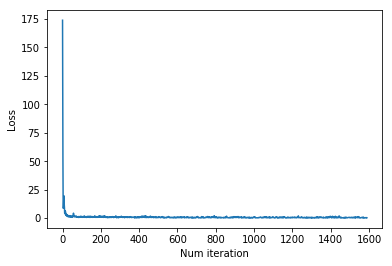

In [0]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel('Num iteration')
plt.ylabel('Loss')


In [0]:
#Test model
model.eval()
with torch.no_grad():
  y_pred_train, y_pred_test = [], []
  loss_train, loss_test = [], []
  pred_train, pred_test = [], []
  true_train, true_test = [], []

  
  for batch in train_dataloader:
    x, y, A = \
      batch['X'].cuda().float(), batch['Y'].cuda().float(), batch['A'].cuda().float()
    pred = model(x, A).squeeze(-1)
    pred_train.append(pred.data.cpu().numpy())
    true_train.append(y.data.cpu().numpy())

    loss_train.append(loss_fn(y, pred).data.cpu().numpy())
  
  for batch in test_dataloader:
    x, y, A = \
      batch['X'].cuda().float(), batch['Y'].cuda().float(), batch['A'].cuda().float()
    pred = model(x, A).squeeze(-1)
    pred_test.append(pred.data.cpu().numpy())
    true_test.append(y.data.cpu().numpy())
    loss_test.append(loss_fn(y, pred).data.cpu().numpy())

pred_train = np.concatenate(pred_train, -1)
pred_test = np.concatenate(pred_test, -1)
true_train = np.concatenate(true_train, -1)
true_test = np.concatenate(true_test, -1)
    
print ('Train loss:', np.mean(np.array(loss_train)))
print ('Test loss:', np.mean(np.array(loss_test)))

Train loss: 0.3838297
Test loss: 0.3970253


Text(0, 0.5, 'Pred')

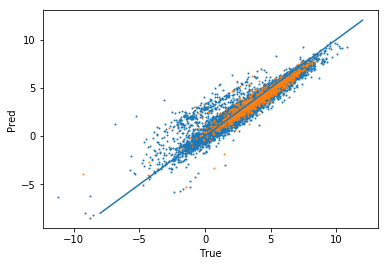

In [0]:

plt.scatter(true_train, pred_train, s=1)
plt.scatter(true_test, pred_test, s=1)

plt.plot([-8,12], [-8,12])
plt.xlabel('True')
plt.ylabel('Pred')
